In [1]:
import os
from pathlib import Path

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import tifffile
from skimage.segmentation import find_boundaries
from skimage.transform import resize

import mip.utils as utils

## Load in data

In [2]:
fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/test/level_4/spatial_features.h5ad'

In [3]:
adata = sc.read_h5ad(fp)
adata

AnnData object with n_obs × n_vars = 3153 × 29
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3e intensity max', 'CD36 intensity max', 'ER intensity max', 'GLUT1 intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'PR intensity max', 'Foxp3 intensity max', 'CK17 intensity max', 'cKIT intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'FGFR3 intensity max', 'GATA3 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min', 'Ki67 intensity min', 'CD68 in

In [4]:
sc.pp.log1p(adata)

In [5]:
adata.var.index.to_list()

['DAPI',
 'CD31',
 'E-cadherin',
 'CD4',
 'CD20',
 'Ki67',
 'CD68',
 'Pan-CK',
 'CD8',
 'Histone H3 Pho',
 'CD163',
 'Podoplanin',
 'CD3e',
 'CD36',
 'ER',
 'GLUT1',
 'SMA',
 'CK19',
 'MGP',
 'Vimentin',
 'PR',
 'Foxp3',
 'CK17',
 'cKIT',
 'HLA-DR',
 'CK14',
 'CD11c',
 'FGFR3',
 'GATA3']

In [7]:
adata.raw = adata

Limit decomposition markers to be only those useful for macro-level cell typing

In [17]:
annotation_marker_map = {
    'Endothelial': ['CD31'],
    'Epithelial': ['E-cadherin', 'Pan-CK'],
    'Macrophage': ['CD68', 'CD163'],
    'T cell': ['CD3e', 'CD4', 'CD8'],
    'Fibroblast/Myo': ['SMA', 'Podoplanin', 'Vimentin'],
}
annotation_markers = [v for k, vs in annotation_marker_map.items() for v in vs]

In [18]:
# I've found it helpful to limit to markers only used in annotation
# This helps keep the clusters cleaner
adata = adata[:, annotation_markers]
adata

View of AnnData object with n_obs × n_vars = 3153 × 11
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3e intensity max', 'CD36 intensity max', 'ER intensity max', 'GLUT1 intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'PR intensity max', 'Foxp3 intensity max', 'CK17 intensity max', 'cKIT intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'FGFR3 intensity max', 'GATA3 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min', 'Ki67 intensity min', 

## Clustering/UMAP

In [19]:
sc.pp.neighbors(adata, n_neighbors=15)

In [20]:
sc.tl.umap(adata)

In [21]:
sc.tl.leiden(adata, resolution=2.)

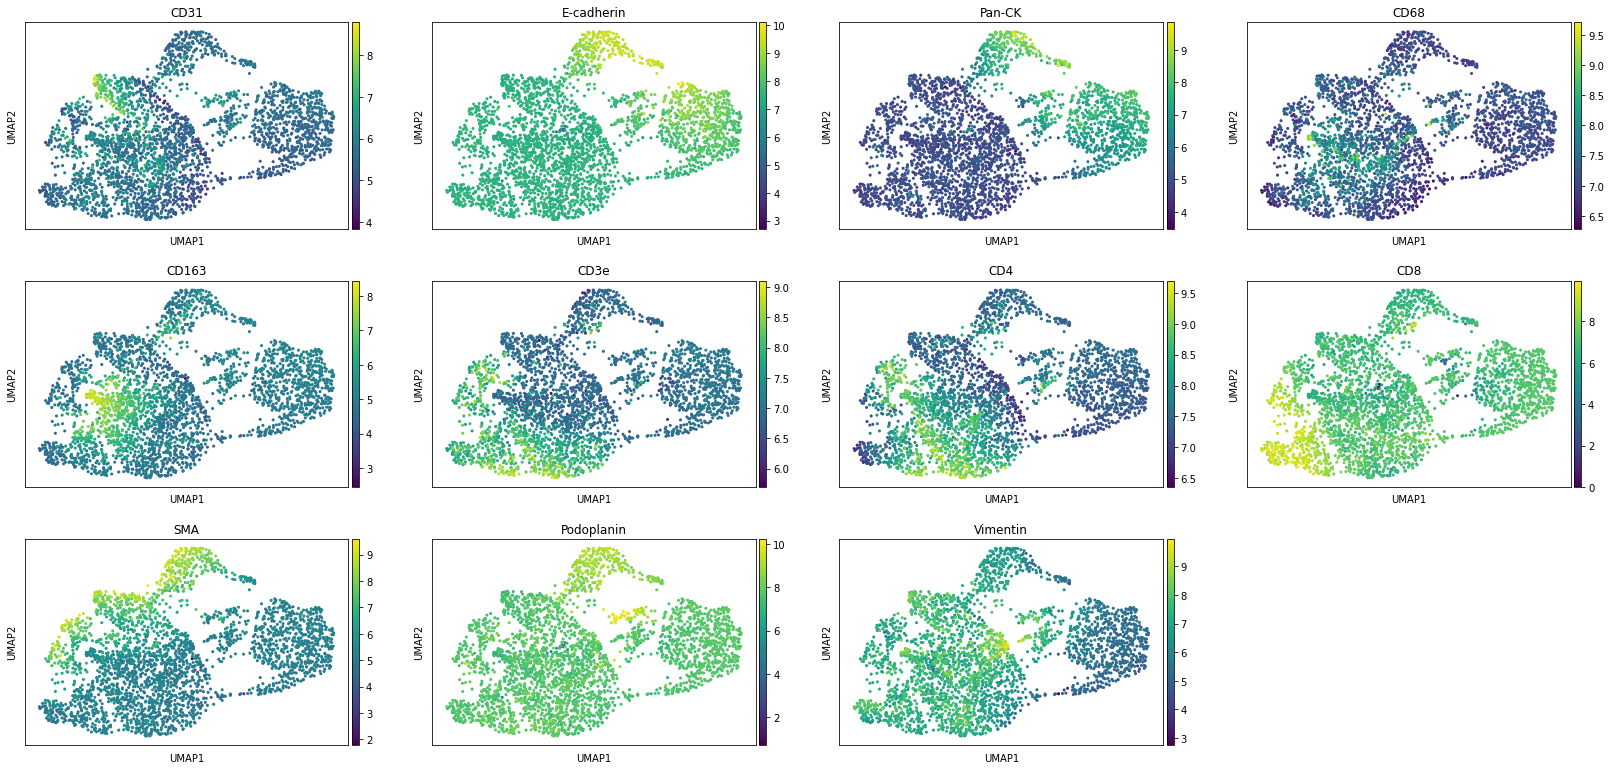

In [22]:
sc.pl.umap(adata, color=annotation_markers)

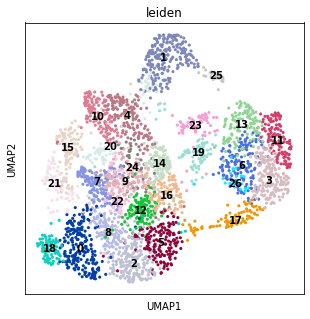

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', ax=ax)

Assigning clusters

In [31]:
cluster_map = {
    'Endothelial': [10],
    'Epithelial': [1, 25, 23, 19, 13, 26, 6, 17, 3, 11],
    'CD8 T cell': [21, 18, 0],
    'CD4 T cell': [2, 8, 5, 12, 15],
    'Macrophage': [7, 9, 22, 20, 24],
    'Stroma': [16, 14, 4],
}

r = {str(v):k for k, vs in cluster_map.items() for v in vs}
adata.obs['cell_type_general'] = [r.get(l, l)
                          for l in adata.obs['leiden']]

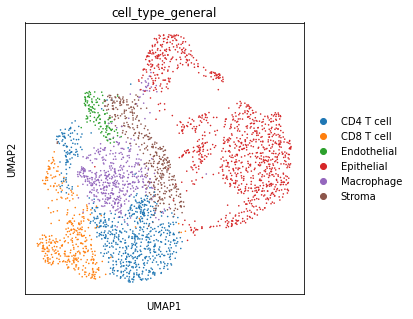

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(adata, color=['cell_type_general'], ncols=1, s=10, ax=ax)

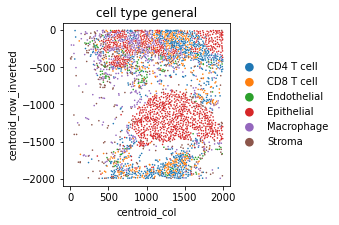

In [35]:
adata.obs['centroid_row_inverted'] = [-x for x in adata.obs['centroid_row']]
fig, ax = plt.subplots(
    figsize=(int(max(adata.obs['centroid_col']) / 500), int(max(adata.obs['centroid_row']) / 500)))
sc.pl.scatter(adata, x='centroid_col', y='centroid_row_inverted', color='cell_type_general', ax=ax, size=10)

## QiTissue gating

Creating cluster file that is imported into QiTissue

In [38]:
df = adata.obs[['cell_type_general']]
df.index.name = 'CellID'
df.columns = ['Cluster']

m = {
    'CD8 T cell': '1',
    'CD4 T cell': '2',
    'Endothelial': '3',
    'Epithelial': '4',
    'Macrophage': '5',
    'Stroma': '6',
}

df['label'] = df['Cluster'].to_list()
df['Cluster'] = [m[x] for x in df['Cluster']]

df.to_csv('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/test/level_4/qitissue_cluster_file.csv')

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [37]:
df

,Cluster,label
CellID,,
1,2,CD4 T cell
2,5,Macrophage
3,5,Macrophage
4,1,CD8 T cell
5,3,Endothelial
...,...,...
3149,2,CD4 T cell
3150,2,CD4 T cell
3151,2,CD4 T cell


## Load QiTissue gates

In [56]:

df = pd.read_csv(
    '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/test/level_4/QiGates.csv',
    index_col=0)
df


,X-Range 1,T cell,CD8 T cell,X-Range 1.1,CD4 T cell,X-Range 1.2,Endothelial,X-Range 2,Epithelial,X-Range 2.1,...,Myoepithelial.1,Myoepithelial.2,X-Range 1.3,X-Range 2.2,Macrophage - M2,Macrophage - M1,Fibroblast,Noise,Fibroblast.1,Fibroblast.2
Cell,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3150,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3151,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cleaning up gating dataframe

In [57]:
exclude = {'X-Range 1', 'X-Range 2', 'Quadrant 1', 'Quadrant 2', 'Quadrant 3', 'Quandrant 4'}
idxs = [c.split('.')[0] for c in df.columns]
df_t = df.transpose()
df_t['gate'] = list(idxs)
df_t = df_t.groupby('gate').sum()
df_t = df_t.loc[[x for x in df_t.index if x not in exclude]]
df = df_t.transpose()
df

gate,CD4 T cell,CD8 T cell,Endothelial,Epithelial,Fibroblast,Macrophage - M1,Macrophage - M2,Myoepithelial,Noise,T cell
Cell,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3149,0,1,0,0,0,0,0,0,0,1
3150,0,0,0,0,0,0,0,0,1,0
3151,1,0,0,0,0,0,0,0,0,1


Taking care of colliding cell type calls

In [58]:
# some gates very slightly overlap resulting in two classifications for a cell
# dealing with that here
# cell types at the front of the list take priority over those at the end
order = ['CD4 T cell', 'CD8 T cell', 'Endothelial', 'Macrophage - M1', 'Macrophage - M2',
         'Myoepithelial', 'Epithelial', 'Fibroblast', 'Noise', 'T cell']
sort_order = {o:i for i, o in enumerate(order)}
for i in df.index.to_list():
    if df.loc[i].sum() > 1:
        val = sorted(df.columns[df.loc[i]==1], key=lambda x: sort_order[x])[0]
        df.loc[i] = [1 if c == val else 0 for c in df.columns]
    elif df.loc[i].sum() < 1:
        df.loc[i] = [1 if c == 'Noise' else 0 for c in df.columns]
df  

gate,CD4 T cell,CD8 T cell,Endothelial,Epithelial,Fibroblast,Macrophage - M1,Macrophage - M2,Myoepithelial,Noise,T cell
Cell,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3149,0,1,0,0,0,0,0,0,0,0
3150,0,0,0,0,0,0,0,0,1,0
3151,1,0,0,0,0,0,0,0,0,0


In [59]:
df.to_csv('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/test/level_4/QiGates.csv')

In [61]:
cell_to_type = {i:df.columns[df.loc[i]==1][0]
               for i in df.index.to_list()}

In [62]:
adata.obs['cell_type'] = [cell_to_type[int(i)] for i in adata.obs.index.to_list()]

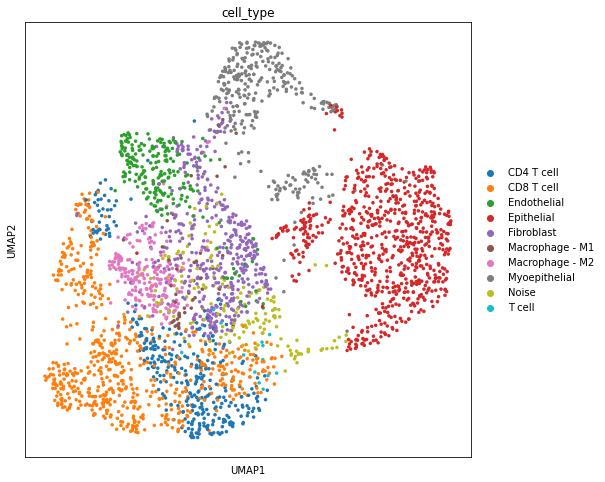

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(adata, color=['cell_type'], ncols=1, s=50, ax=ax)

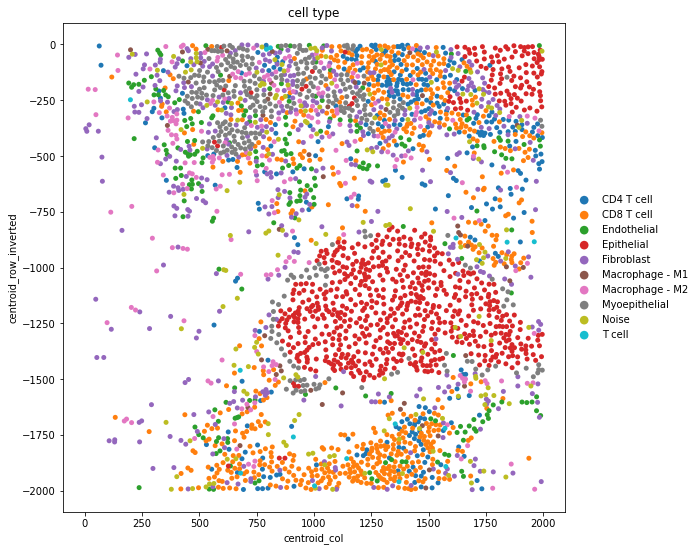

In [69]:
fig, ax = plt.subplots(
    figsize=(int(max(adata.obs['centroid_col']) / 200), int(max(adata.obs['centroid_row']) / 200)))
sc.pl.scatter(adata, x='centroid_col', y='centroid_row_inverted', color='cell_type', size=100, ax=ax)

save results

In [70]:
adata.write_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/test/level_4/cell_annotation.h5ad')